### CS6220 Data Mining Techniques - Final Project


### Group Centaurus
- Lu Liu, Ke Yang, Mengshi Li, Jing Shen, Siyu Chen

### Timeline

- [ ] **3.13 Environment setup - Github Jing**
    - jshen1110 / syche55 / lulu814 / Li-Mengshi-1996 / yangke928
- [ ] **3.21 - 4.3 Data Processing Ke / Lu / (Siyu)**
    - Features selection Cleaning PCA 
    
> **Feature**: 2.Name 4.Genres 7.Type  8.Episodes 9.Aired 11.Producers 14.Source 15.Duration 16. Rating 18.Popularity 

> **Target**: 3.Score
- [ ] **4.3 - 4.10 Model Implement**
    - Unsupervised Siyu / Jing
    - Supervised Mengshi
- [ ] **4.10 - 4.17 Result Analysis & Visualization All**
- [ ] **4.17 - 4.23 Report All**

In [898]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler

warnings.filterwarnings("ignore") 

### Data Pre-processing

In [899]:
anime_data=pd.read_csv('dataset/anime.csv')

Before we were able to use the data, we first had to clean it by removing the unnecessary columns and missing values.

First we will check the anime data. Since it is a large data set, we will check the data shape and columns to determine how many records and features we have in the raw data set.

In [900]:
print("anime data shape: ", anime_data.shape)
print("data features include: \n", anime_data.dtypes)

anime data shape:  (17562, 35)
data features include: 
 MAL_ID            int64
Name             object
Score            object
Genres           object
English name     object
Japanese name    object
Type             object
Episodes         object
Aired            object
Premiered        object
Producers        object
Licensors        object
Studios          object
Source           object
Duration         object
Rating           object
Ranked           object
Popularity        int64
Members           int64
Favorites         int64
Watching          int64
Completed         int64
On-Hold           int64
Dropped           int64
Plan to Watch     int64
Score-10         object
Score-9          object
Score-8          object
Score-7          object
Score-6          object
Score-5          object
Score-4          object
Score-3          object
Score-2          object
Score-1          object
dtype: object


Then we compute the summary statistics for each feature available in the dataset, including the minimum value, maximum value, mean value, standard deviation, count, and 25:50:75% percentiles to have a better understanding of the data.

In [901]:
anime_data.describe()

,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


To better understand our feature set and intrinsic relationships amongst features, the following correlation matrices  were generated. The correlation matrix shows many expected behaviors. For example, a strong positive correlation between Members, Favorites, and Watching. The negative correlation between Popularity and other features is because that it is the position based in the the number of users who have added the anime to their list: the smaller the value is, the more popular it is.

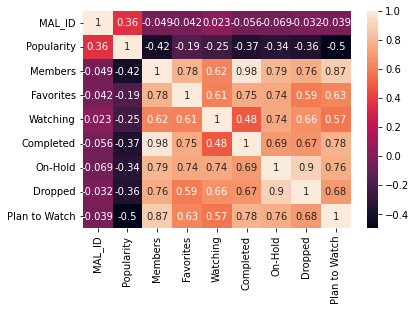

In [902]:
corrMatrix = anime_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Next we want to check if there is any missing values in the dataset.

In [903]:
anime_data.isnull().values.any()

False

Although it shows that there is no missing value or null value in the data set, after we manually inspected the data, we found that the dataset replaced the null or missing value with "Unknown". To preprocess the missing values in the dataset, we replace the "Unknown" back to NaN value.

In [904]:
anime_data.replace(to_replace="Unknown", value= np.NaN, inplace=True)
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          12421 non-null  object
 3   Genres         17499 non-null  object
 4   English name   6997 non-null   object
 5   Japanese name  17514 non-null  object
 6   Type           17525 non-null  object
 7   Episodes       17046 non-null  object
 8   Aired          17253 non-null  object
 9   Premiered      4745 non-null   object
 10  Producers      9768 non-null   object
 11  Licensors      3946 non-null   object
 12  Studios        10483 non-null  object
 13  Source         13995 non-null  object
 14  Duration       17007 non-null  object
 15  Rating         16874 non-null  object
 16  Ranked         15800 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

From the result, we can see that features that have most null value percentages are as follows: 
- English name has 60% null values 
- Premiered has 73% null values 
- Licensors has 78% null values

Since these features are not very important to our analysis as well, we will drop these features directly.

For the features of 'Score-10' to 'Score-1', they are indicating the number of users who scored the anime 10 to 1. Since we already have the mean score in the features and will mainly focus on it, we will drop these score count columns to reduce the features we want to consider. We will also drop the feature 'Ranked' as it is the position based on the score column.

For the rest of features, since the features 'MAL_ID', 'Name', and 'Japanese name' provide the same information about the anime, we will only keep 'Name' as the unique identifier for the anime; feature 'Studios' has similar information with other more important features such as 'Producers', so we will also drop it.

There are also some features that provide additional information that we will not use in our analysis, such as member information and the number of users that are watching, dropped, completed, on-hold, dropped, or plan to watch. We will also drop these features to reduce our feature dimensions.

Therefore, we will only keep the following features for the future analysis:
- Name: full name of the anime. 
- Score: average score of the anime given from all users in MyAnimelist database.
- Genres: comma separated list of genres for this anime.
- Type: TV, movie, OVA, etc.
- Episodes: number of chapters.
- Aired: broadcast date.
- Producers: comma separated list of produducers.
- Source: Manga, Light novel, Book, etc. (e.g Original)
- Duration: duration of the anime per episode 
- Rating: age rate (e.g. R - 17+ (violence & profanity))
- Popularity: position based in the the number of users who have added the anime to their list. 

In [905]:
keep_cols = ['Name', 'Score', 'Genres', 'Type', 'Episodes', 'Aired', 'Producers', 'Source', 'Duration', 'Rating', 'Popularity']
anime_data = anime_data[keep_cols]

Since it is hard to fill the descriptive NaN values and we have a large dataset, we will drop all the records that have NaN values in the rest of features to get a clean dataset.

In [906]:
anime_data.dropna(inplace=True)
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6633 entries, 0 to 17552
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        6633 non-null   object
 1   Score       6633 non-null   object
 2   Genres      6633 non-null   object
 3   Type        6633 non-null   object
 4   Episodes    6633 non-null   object
 5   Aired       6633 non-null   object
 6   Producers   6633 non-null   object
 7   Source      6633 non-null   object
 8   Duration    6633 non-null   object
 9   Rating      6633 non-null   object
 10  Popularity  6633 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 621.8+ KB


We noticed that features 'Score' and 'Episodes' are in the object data type instead of numeric data type. We will convert them to numeric data type for the further analysis purpose.

In [907]:
anime_data['Score'] = pd.to_numeric(anime_data['Score'])
anime_data['Episodes'] = pd.to_numeric(anime_data['Episodes'])

Let's take a look at the first 5 rows of the anime table:

In [908]:
anime_data.head(5)

,Name,Score,Genres,Type,Episodes,Aired,Producers,Source,Duration,Rating,Popularity
0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
1,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,"Sep 1, 2001","Sunrise, Bandai Visual",Original,1 hr. 55 min.,R - 17+ (violence & profanity),518
2,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26,"Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,Manga,24 min. per ep.,PG-13 - Teens 13 or older,201
3,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26,"Jul 2, 2002 to Dec 24, 2002","TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Original,25 min. per ep.,PG-13 - Teens 13 or older,1467
4,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52,"Sep 30, 2004 to Sep 29, 2005","TV Tokyo, Dentsu",Manga,23 min. per ep.,PG - Children,4369


Now we can check some of the feature distributions and trends in the dataset. 

- From the "Anime Count by Type" chart below, we can see that TV has the most popular anime type among all kinds of anime release types. 
- From the "Anime Count by Source" chart below, we can see that Manga is the most popular source and original is the second populer source among all kinds of anime sources.

Type
Movie       783
Music       287
ONA         408
OVA        1684
Special     562
TV         2909
dtype: int64


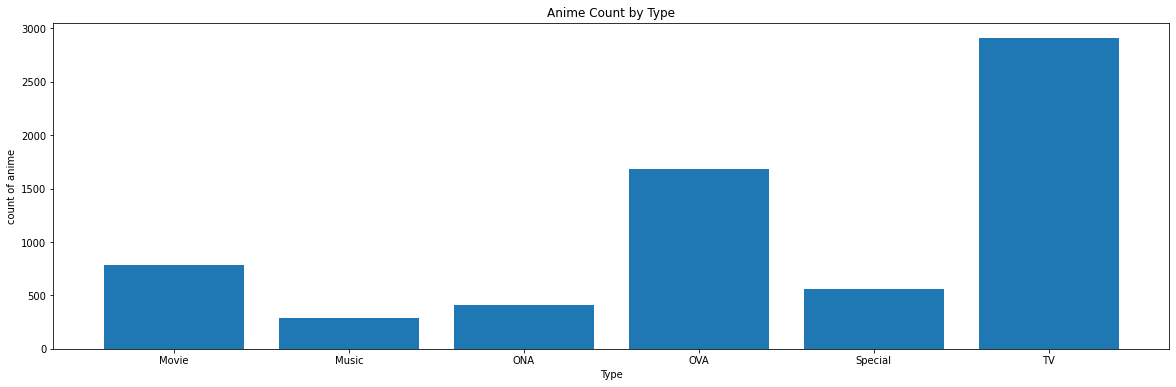

In [909]:
type_count = anime_data.groupby('Type').size()
print(type_count)

plt.figure(figsize=(20, 6))
plt.title("Anime Count by Type")
plt.bar(type_count.index.tolist(), type_count.tolist())
plt.ylabel('count of anime')
plt.xlabel('Type');

Source
4-koma manga      179
Book               37
Card game          37
Digital manga       4
Game              409
Light novel       510
Manga            2335
Music             118
Novel             264
Original         1692
Other             153
Picture book       20
Radio               3
Visual novel      732
Web manga         140
dtype: int64


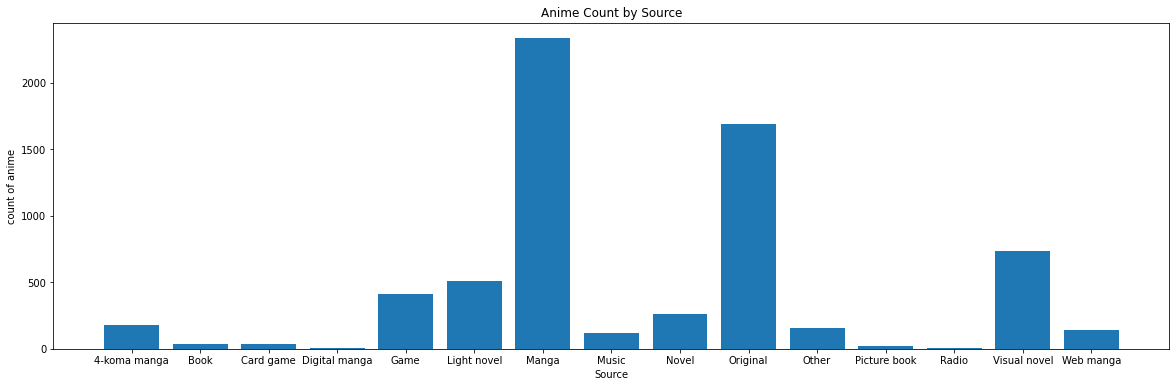

In [910]:
source_count = anime_data.groupby('Source').size()
print(source_count)
plt.figure(figsize=(20, 6))
plt.title("Anime Count by Source")
plt.bar(source_count.index.tolist(), source_count.tolist())
plt.ylabel('count of anime')
plt.xlabel('Source');

Since many anime belong to more than one genre, if we want to check the statistics related to genre, we need first flatten the data. 

In [911]:
anime_data_flatten = anime_data.assign(Genres=anime_data['Genres'].str.split(', ')).explode('Genres')
anime_data_flatten

,Name,Score,Genres,Type,Episodes,Aired,Producers,Source,Duration,Rating,Popularity
0,Cowboy Bebop,8.78,Action,TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
0,Cowboy Bebop,8.78,Adventure,TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
0,Cowboy Bebop,8.78,Comedy,TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
0,Cowboy Bebop,8.78,Drama,TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
0,Cowboy Bebop,8.78,Sci-Fi,TV,26,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Original,24 min. per ep.,R - 17+ (violence & profanity),39
...,...,...,...,...,...,...,...,...,...,...,...
17374,Senyoku no Sigrdrifa: Dai-909 Senjutsu Hime-ta...,5.87,Military,Special,1,"Nov 28, 2020",Aniplex,Original,24 min.,PG-13 - Teens 13 or older,9167
17469,Wave!!: Surfing Yappe!! (TV),6.05,Slice of Life,TV,12,"Jan 12, 2021 to ?",Delfi Sound,Other,23 min. per ep.,PG-13 - Teens 13 or older,3678
17469,Wave!!: Surfing Yappe!! (TV),6.05,Sports,TV,12,"Jan 12, 2021 to ?",Delfi Sound,Other,23 min. per ep.,PG-13 - Teens 13 or older,3678
17552,SK∞: Crazy Rock Jam,6.52,Comedy,Special,1,"Mar 14, 2021","Aniplex, Movic, ABC Animation",Original,23 min.,PG-13 - Teens 13 or older,4830


We can calculate the average score of different genres. Thriller has the highest average score and Dementia has the lowest score among all 43 genres.

In [912]:
mean_score = anime_data_flatten.groupby('Genres').agg({'Score':[np.mean]}).sort_values(by=[('Score', 'mean')], ascending=False)
mean_score

,Score
,mean
Genres,
Thriller,7.450667
Mystery,7.228188
Psychological,7.204498
Samurai,7.182299
Shounen,7.177905
Drama,7.154153
Seinen,7.114699
Cars,7.110313


We analyze the total number of producers. Because the number of producers is too large, here we only pick up the Top 25 producers.

In [913]:
anime_data_flatten = anime_data.assign(Producers=anime_data['Producers'].str.split(', ')).explode('Producers')
source_count = anime_data_flatten.groupby('Producers').size().sort_values(ascending=False)
print(source_count.shape)
print(source_count.head(25))
producer_list = source_count.head(25).index.values.tolist()

(1145,)
Producers
Aniplex                         458
Lantis                          421
TV Tokyo                        391
Bandai Visual                   351
Movic                           306
AT-X                            283
Pony Canyon                     276
Sotsu                           275
Dentsu                          273
Fuji TV                         231
KlockWorx                       222
Shueisha                        216
Kodansha                        211
TBS                             194
Mainichi Broadcasting System    193
Kadokawa Shoten                 185
DAX Production                  179
NHK                             178
Pink Pineapple                  173
Genco                           156
Starchild Records               150
Media Factory                   148
Sony Music Entertainment        127
Frontier Works                  126
Kadokawa                        119
dtype: int64


#### PCA preprocessing
1. Reduce the number of classes in catalog data. For example, in previous work we found the "Type" catalog contains 3 main classes "TV", "OVA" and "Movie", then we can set other smaller-size classes as "OtherType".
2. Convert the catalog data to numeric data. Because the PCA decomposition method can only accept numeric data, here we use one hot encoding method to convert partial catalog data to multiple columns of binary data. If the entry contains the specified catalog, the related encoded binary value is set to 1, othervise it is set to 0.
3. Standarize the numerical data. Here we use min-max standarization to ensure the uniformity of different columns.
4. Remove the "Unknown" value in the dataset. The None type is not recognizable in PCA method, so we need to remove them.

In [914]:
## Preprocessing data and pca transfer

usecols = ['Name', 'Score', 'Genres', 'Type', 'Episodes', 'Aired', 'Producers', 'Source', 'Duration', 'Rating', 'Popularity']
anime_data=pd.read_csv('dataset/anime.csv',usecols=usecols)

def process_type(series):
    return series if series in ["TV", "OVA", "Movie"] else "OtherType"

def process_aired(series):
    for i in series.split(" "):
        if len(i) == 4 and i[:2] in ["19", "20"]:
            return int(i)
    return np.NaN

def process_source(series):
    if series in ["Original", "Manga"]:
        return series
    elif series in ["Light novel", "Visual novel"]:
        return "Novel"
    else:
        return "OtherSource"

def process_duration(series):
    if series == "Unknown":
        return np.NaN
    series = series.split(" ")
    if series[1] == "hr.":
        return int(series[0])*60 + (int(series[2]) if len(series) > 2 and series[3] == "min." else 0)
    else:
        return int(series[0])

def process_rating(series):
    return series.split(" ")[0]

def process_producer(series):
    list = []
    for producer in series:
        if producer in producer_list:
            list.append(producer)
    return list

def process_multilabel(series):
    series = series.split(", ")
    return series


anime_data["Type"] = anime_data["Type"].map(process_type)
anime_data["Aired"] = anime_data["Aired"].map(process_aired)
anime_data["Source"] = anime_data["Source"].map(process_source)
anime_data["Duration"] = anime_data["Duration"].map(process_duration)
anime_data["Rating"] = anime_data["Rating"].map(process_rating)
anime_data["Genres"] = anime_data["Genres"].map(process_multilabel)
anime_data["Producers"] = anime_data["Producers"].map(process_multilabel).map(process_producer)


def preprocessing_category(df, column, is_multilabel=False):
    # Binarise labels
    lb = LabelBinarizer()
    if is_multilabel:
        lb = MultiLabelBinarizer()
        
    expandedLabelData = lb.fit_transform(df[column])
    labelClasses = lb.classes_

    # Create a pandas.DataFrame from our output
    category_df = pd.DataFrame(expandedLabelData, columns=labelClasses)
    del df[column]
    return pd.concat([df, category_df], axis=1)

def preprocessing_numeric(df, column, type):
    df[column] = df[column].replace("Unknown", np.NaN)
    null_index = df[column].isnull()
    df.loc[~null_index, [column]] = df.loc[~null_index, [column]].astype(type)
    df.loc[~null_index, [column]] = MinMaxScaler().fit_transform(df.loc[~null_index, [column]])
    return df

anime_OHEdata = anime_data.copy()

anime_OHEdata = preprocessing_numeric(anime_OHEdata, "Score", float)
anime_OHEdata = preprocessing_numeric(anime_OHEdata, "Episodes", int)
anime_OHEdata = preprocessing_numeric(anime_OHEdata, "Popularity", int)
anime_OHEdata = preprocessing_numeric(anime_OHEdata, "Aired", int)
anime_OHEdata = preprocessing_numeric(anime_OHEdata, "Duration", int)
anime_OHEdata = preprocessing_category(anime_OHEdata, "Type")
anime_OHEdata = preprocessing_category(anime_OHEdata, "Source")
anime_OHEdata = preprocessing_category(anime_OHEdata, "Rating")
anime_OHEdata = preprocessing_category(anime_OHEdata, "Genres", is_multilabel=True)
anime_OHEdata = preprocessing_category(anime_OHEdata, "Producers", is_multilabel=True)

## PCA cannot deal with np.NaN
anime_OHEdata = anime_OHEdata.dropna()

Name = anime_OHEdata[["Name"]]
del anime_OHEdata["Name"]

anime_OHEdata = anime_OHEdata.values

## Temperary set N_components to 25
pca = PCA(n_components=25)
reduced_anime_OHEdata = pca.fit_transform(anime_OHEdata)
reduced_anime_OHEdata



array([[ 7.76916328e-01, -2.99897457e-01,  1.27018546e+00, ...,
         4.41777680e-01, -1.63446340e-01,  1.60137654e-01],
       [ 1.44663108e-04, -8.05133952e-02,  1.62864081e+00, ...,
         3.13549468e-01, -8.76950846e-02, -2.06488810e-01],
       [ 1.75389975e+00, -8.70415033e-02,  5.64802534e-01, ...,
         3.59570573e-01, -1.30282942e-01,  5.40329581e-03],
       ...,
       [-5.50091878e-01, -6.57876995e-01, -8.74301088e-01, ...,
         5.44054782e-03,  3.17169518e-01, -1.14972859e-02],
       [ 6.62200639e-02,  1.63594148e-01, -1.60701131e-01, ...,
        -5.33519226e-02,  2.01708451e-01, -4.04767316e-01],
       [ 1.25216089e-01, -5.41253872e-01, -6.93096469e-01, ...,
        -8.15282268e-02,  6.49610641e-02, -2.40532426e-01]])